# 등온위면 분석
- 대기의 운동이 단열적임을 가정함
- 등온위면을 가로질러 고도가 낮은 쪽에서 높은 쪽으로 부는 바람이 있을 때 상승 기류가 있다고 추정
- https://unidata.github.io/python-training/gallery/isentropic_interpolation/ 참조

In [1]:
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.plots import add_timestamp
import metpy.calc as mpcalc
from metpy.units import units

In [11]:
dt = datetime(2021,9,21,0)
gh = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'shortName':'gh'}})
u = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'shortName':'u'}})
v = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'shortName':'v'}})
t = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'shortName':'t'}})
q = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'shortName':'q'}})

ds = gh
for var in [u,v,t,q]:
    ds = ds.merge(var)
data = ds.sel(isobaricInhPa=[1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,  650.,
        600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,  200.,  150.,
        100.],latitude=slice(90,0), longitude=slice(60,201))
lats = data.latitude.data
lons = data.longitude.data

In [44]:
isentlevs = [310.] * units.kelvin

In [45]:
isent_data = mpcalc.isentropic_interpolation_as_dataset(
    isentlevs,
    data['t'],
    data['u'],
    data['v'],
    data['q'],
    data['gh']
)

C:\Users\DongGyu_Hyeon\miniconda3\envs\anl\lib\site-packages\metpy\xarray.py:349: UserWarning: More than one time coordinate present for variable "t".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
C:\Users\DongGyu_Hyeon\miniconda3\envs\anl\lib\site-packages\metpy\interpolate\one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


In [46]:
isent_data

Magnitude,[[[297.0898215600151 297.0898215600151 297.0898215600151 ... 297.0898215600151 297.0898215600151 297.0898215600151] [296.6754145029884 296.74812352342684 296.85628602746056 ... 309.1885920121757 309.36630442099295 309.5082587440123] [294.2543688460915 294.37928867527455 294.50132281507615 ... 370.20404127139034 369.2372151533646 368.31185963041025] ... [750.1039638464808 750.1017447597006 749.8573676680542 ... 764.8054586444642 758.2994252974402 755.8246895104136] [745.9339185619287 739.7172617763176 741.7768653217753 ... 761.5653554231778 757.9284123896216 748.0626210530675] [742.1211431195569 735.7778154326307 742.5051343751243 ... 760.1056874683942 756.9748522904692 741.7800078918781]]]
Units,hectopascal
Magnitude,[[[219.15843998862988 219.15843998862988 219.15843998862988 ... 219.15843998862988 219.15843998862988 219.15843998862988] [219.07105315596732 219.08639175441812 219.10920460643976 ... 221.67221163879586 221.708607195963 221.73766875875046] [218.55877221342993 218.58527812985054 218.61116399407655 ... 233.3775986259271 233.20329603990757 233.03616431662573] ... [285.5499648930707 285.54972353192903 285.52314049745877 ... 287.13791662696667 286.4378946355351 286.1704971115007] [285.09550292866334 284.4146147936209 284.6406470146974 ... 286.78982901465986 286.3978461014624 285.3277203514026] [284.6783862095378 283.9810229895851 284.7204639820858 ... 286.6326697079098 286.29485094018844 284.6409915549015]]]
Units,kelvin
Magnitude,[[[-0.6994556753579201 -0.6942519032644782 -0.5890481669338231 ... 2.3589141345160884 2.348506565515662 2.34330279342222] [5.385515823518757 5.578878815263602 5.677832527539222 ... 11.774054728176456 11.413742462700382 11.143270481783652] [7.619222962686663 7.883049353739484 8.158191511104942 ... 10.076963335244727 9.998631903266851 9.910369855878285] ... [1.1636667814599173 1.7035773610591598 1.922347756371344 ... -18.626988397908114 -18.95365883014884 -19.042178918603085] [0.49431419195991894 1.4019607863140922 1.9332276826644015 ... -17.85916288612303 -18.54469502497234 -18.683348003813666] [-0.48061267969921156 0.20887396009544323 1.2421858135707995 ... -17.63467837745379 -17.66385001195314 -16.086513883470168]]]
Units,meter/second
Magnitude,[[[2.7832815798858954 2.7780777829789107 2.7780777829789107 ... -1.619228395191676 -1.7192283942199913 -1.7192283942199913] [3.9814550381637472 3.8863267196727325 3.795965488397941 ... -8.652527348476191 -8.776919408876399 -8.942204918947464] [4.416948523833761 4.40957009151272 4.412414488218088 ... -12.403248738497481 -12.795160464515067 -13.158437560887199] ... [4.277458397168242 4.076558351521779 3.6676588268961092 ... 0.9806676059001982 1.4281919672371335 1.8621573158160754] [4.838035470485904 5.133610326352784 5.814722729749247 ... 2.3880323887207284 2.826268662066095 3.133508287708097] [5.036556343674993 5.530192942625133 5.799079431246712 ... 2.1227720224203184 2.9428432794930925 2.586137503669951]]]
Units,meter/second
Magnitude,[[[4.730119986257357e-05 4.730119986257357e-05 4.730119986257357e-05 ... 4.730119986257357e-05 4.730119986257357e-05 4.730119986257357e-05] [4.5343163132963134e-05 4.553533461612854e-05 4.5750669599004865e-05 ... 6.672022823847108e-05 6.70335648542671e-05 6.729187108782011e-05] [3.9596512720965475e-05 3.9866680213831754e-05 4.0137437867212105e-05 ... 0.0002297420404605678 0.00022591422615261597 0.00022218985055389787] ... [0.006521216461642111 0.006669577761812663 0.005792589820776072 ... 0.004883353962626447 0.0050497213410836865 0.0049765435499869465] [0.007404626599477654 0.007753609928763389 0.007615189772726102 ... 0.005374381673321485 0.005372410799185745 0.0052784856441520376] [0.008313266058218947 0.008821989611798128 0.008189176752375684 ... 0.006131230944462116 0.0070572524388189 0.00806944596538807]]]
Units,dimensionless
Magnitude,[[[8856.623548457485 8856.623548457485 8856.623548457485 ... 8856.623548457485 8856.623548457485 8856.623548457485] [8868.434865781981 8867.033007467926 8864.850295341957 

In [47]:
isent_data['u'] = isent_data['u'].metpy.convert_units('kt')
isent_data['v'] = isent_data['v'].metpy.convert_units('kt')
isent_data['Relative_humidity'] = mpcalc.relative_humidity_from_specific_humidity(
    isent_data['pressure'],
    isent_data['temperature'],
    isent_data['q']
).metpy.convert_units('percent')

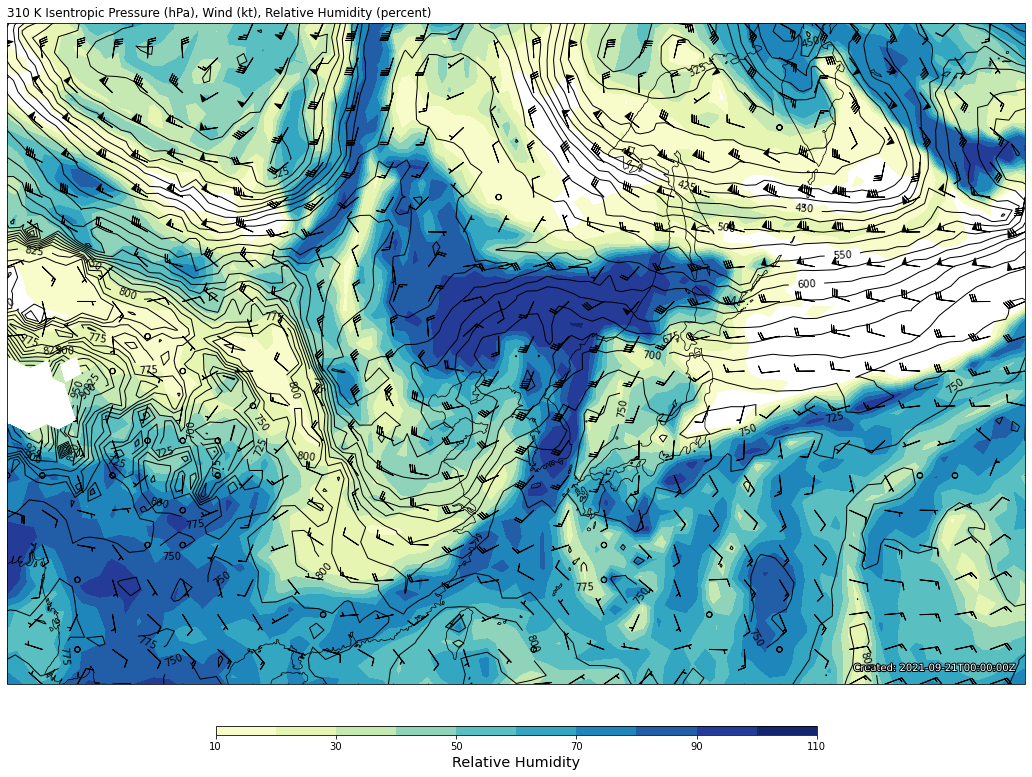

In [51]:
# Set up our projection
crs = ccrs.LambertConformal(central_longitude=125., central_latitude=30.0)

# Coordinates to limit map area
bounds = [(90., 160., 20., 60.)]
# Choose a level to plot, in this case 296 K
level = 0

fig = plt.figure(figsize=(17., 12.))
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Plot the surface
clevisent = np.arange(0, 1000, 25)
cs = ax.contour(lons, lats, isent_data['pressure'][level, :, :], clevisent,
                colors='k', linewidths=1.0, linestyles='solid', transform=ccrs.PlateCarree())
ax.clabel(cs, fontsize=10, inline=1, inline_spacing=7,
          fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot RH
cf = ax.contourf(lons, lats, isent_data['Relative_humidity'][level, :, :], range(10, 115, 10),
                 cmap='YlGnBu', transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=0.5, pad=0.05)
cb.set_label('Relative Humidity', size='x-large')

# Plot wind barbs
ax.barbs(lons, lats, isent_data['u'].isel(isentropic_level=level).values, isent_data['v'].isel(isentropic_level=level).values, length=6,
         regrid_shape=20, transform=ccrs.PlateCarree())

# Make some titles
ax.set_title('{:.0f} K Isentropic Pressure (hPa), Wind (kt), Relative Humidity (percent)'
             .format(isentlevs[level].m), loc='left')
add_timestamp(ax, isent_data['time'].values.astype('datetime64[ms]').astype('O'),
              y=0.02, high_contrast=True)
fig.tight_layout()